In [1]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO

# standard import
import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
class RotatingTwoMoonsConditionalSampler(object):
    def __init__(self, noise=0.05, random_seed=42):
        self.noise = noise
        #self.random_seed = random_seed
        self.rotation_sampler = torch.distributions.uniform.Uniform(low=0, high=2*np.pi)
        self.translation_sampler = torch.distributions.uniform.Uniform(low=-4, high=4)

    
    def conditioned_sample(self, n_samples=100,  theta=torch.tensor([0])):
        # Draw two moon samples and translate
        X, y = make_moons(n_samples=n_samples, shuffle=True, noise=self.noise)
        X_t = X - [0.5, 0.25]

        # Rotate points by theta radians
        X_r = self._rotate_points(X_t, theta).astype(np.float32)
        
        return  torch.from_numpy(X_r), torch.from_numpy(y)

    def conditioned_translated_sample(self, n_samples=100, theta=torch.tensor([0.]), trans=torch.tensor([0.,0.])):
        # Draw two moon samples, rotate and translate
        X, y = make_moons(n_samples=n_samples, shuffle=True, noise=self.noise)
        X_t = X - [0.5, 0.25]
        X_r = self._rotate_points(X_t, theta).astype(np.float32)
        
        X_r = torch.from_numpy(X_r)
        X_tf = X_r + trans
        
        return  X_tf.type(torch.FloatTensor), torch.from_numpy(y), theta, trans


    def joint_sample(self, n_samples):
        # Samples covariates
        theta = self.rotation_sampler.sample(sample_shape=[n_samples,1])
        
        # Draw two moon samples and translate
        X, y = make_moons(n_samples=n_samples, shuffle=True, noise=self.noise)
        X_t = X - [0.5, 0.25]
        
        # Rotate points based on covariates
        X_r = self._rotate_points(X_t, theta).astype(np.float32)
        
        return  torch.from_numpy(X_r), torch.from_numpy(y), theta

    def joint_translation_sample(self, n_samples):
        # Sample covariates
        theta = self.rotation_sampler.sample(sample_shape=[n_samples,1])
        trans = self.translation_sampler.sample(sample_shape=[n_samples, 2])

        # Draw two moon samples and rotate points
        X,y = make_moons(n_samples=n_samples, shuffle=True, noise=self.noise)
        X_t = X - [0.5, 0.25]
        X_r = self._rotate_points(X_t, theta).astype(np.float32)


        X_r = torch.from_numpy(X_r)
        X_tf = X_r + trans


        return X_tf.type(torch.FloatTensor), torch.from_numpy(y), theta, trans

    def make_plot(self, n_samples=100, theta=0):
        """
        Function used to make fancy plot
        """
        X, y = self.conditioned_sample(n_samples=n_samples, theta=theta, input_is_degrees=True)
        fig = plt.figure()
        axe = ax = fig.gca()
        axe.set_xlim(-2, 2)
        axe.set_ylim(-2, 2)
        sp, = axe.plot(X[:,0], X[:,1],color='k',marker='o',ls='')
        
        plt.show()
        return fig, axe, sp
    
    def update_plot(self, fig, axe, sp, n_samples=100, theta=0):
        """
        Function used to make fancy plot
        """
        X, y = self.conditioned_sample(n_samples=n_samples, theta=theta, input_is_degrees=True)
        sp.set_data(X[:,0],X[:,1])
        fig.canvas.draw()
                
    def _create_rotation_matrix(self, theta):
        c = np.cos(theta)
        s = np.sin(theta)
        m = np.array([[c, -s], [s, c]])
        return m

    def _rotate_points(self, x_arr, theta):
        if theta.shape[0] == 1:
            m = self._create_rotation_matrix(theta)
            return np.array([np.dot(m,x) for x in x_arr])
        else:
            return np.array([np.dot(self._create_rotation_matrix(theta[i]), x_arr[i]) for i in range(len(x_arr))])
    
    def _degrees_to_radians(self, degrees):
        return degrees * np.pi / 180

In [3]:
plt.style.use("ggplot")

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]

This Notebook implements a (Conditional) Normalizing Flow (as in RealNVP) on a RotatingTwoMoons Dataset. The conditioning variable (i.e. context variable) represents an indicator function of the rotation applied to the Two Moons.

### Data 

In [5]:
'''# Generate 10 rotated versions of the TwoMoons dataset and visualize
_X_H = torch.zeros((10, 1024, 2))
_H = torch.zeros((10, 1024, 1))
pis = np.linspace(0, 2, 10)
for i, pi in enumerate(pis):
    cond_two_moons = RotatingTwoMoonsConditionalSampler()
    x, y = cond_two_moons.conditioned_sample(1024, theta=torch.tensor([np.pi*pi]))
    plt.figure(figsize=(4,4))
    plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
    plt.axis('equal')
    plt.show()
    _X_H[i] = x
    _H[i] = torch.zeros(1024,1) + i'''

"# Generate 10 rotated versions of the TwoMoons dataset and visualize\n_X_H = torch.zeros((10, 1024, 2))\n_H = torch.zeros((10, 1024, 1))\npis = np.linspace(0, 2, 10)\nfor i, pi in enumerate(pis):\n    cond_two_moons = RotatingTwoMoonsConditionalSampler()\n    x, y = cond_two_moons.conditioned_sample(1024, theta=torch.tensor([np.pi*pi]))\n    plt.figure(figsize=(4,4))\n    plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)\n    plt.axis('equal')\n    plt.show()\n    _X_H[i] = x\n    _H[i] = torch.zeros(1024,1) + i"

In [12]:
from bayesace.models.utils import get_data

# build data-iterator
df = get_data(44091)
#df = df[["V1","V2","V3","class"]]
print(len(df))
print(df["class"].cat.categories)
# Transform dataset to numpy and cast class from string to numerical
class_column = np.zeros(len(df))
for i, label in enumerate(df["class"].cat.categories):
    class_column[df["class"] == label] = i
df["class"] = class_column
print(df["class"])

df_test = df.tail(2000)
df = df.head(len(df)-2000)

features = df.columns[:-1]
print(len(features))

t_y_val = torch.Tensor(df_test["class"].values).view(-1,1)
t_x_val = torch.Tensor(df_test[features].values).view(-1,len(features))

#H = _H.view(-1,1)
#X_H = _X_H.view(-1,2)
t_y = torch.Tensor(df["class"].values).view(-1,1)
t_x = torch.Tensor(df[features].values).view(-1,len(features))
dataset = Dataset(t_y,t_x)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256,
                        shuffle=True, num_workers=0)

2554
Index(['False', 'True'], dtype='string')
0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
2549    0.0
2550    1.0
2551    0.0
2552    0.0
2553    1.0
Name: class, Length: 2554, dtype: float64
11


In [13]:
for i in dataloader :
    print(i)

[tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
     

In [26]:
from bayesace.models.conditional_normalizing_flow_nvp import ConditionalNormalizingFlow

# Build NF model
cnf = ConditionalNormalizingFlow(input_dim=len(features), split_dim=5, context_dim=1, hidden_dim=11*10, num_layers=2, flow_length=10, 
                    use_cuda=False)

11 5 1 110 2 10


In [27]:
# Build SVI object
optimizer = pyro.optim.Adam({"lr": 0.0001})
svi = SVI(cnf.model, cnf.guide, optimizer, Trace_ELBO(num_particles=1))

In [28]:
print("number of params: ", sum(p.numel() for p in nn.ModuleList(cnf.transforms).parameters()))

number of params:  143120


In [31]:
num_epochs = 1000
losses = []
pyro.clear_param_store()
epochs = tqdm.trange(num_epochs)

for epoch in epochs:
    try:
        running_loss = 0
        for x_batch, y_batch in dataloader:
            #print(x_batch.shape)
            if cnf.use_cuda:
                y_batch, x_batch = y_batch.cuda(), x_batch.cuda()
            loss = svi.step(y_batch, x_batch)
            running_loss += float(loss)
            del x_batch, y_batch
            del loss
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
        # Checkpoint model
#         if running_loss <= best_loss:
#             torch.save(cnf, "cnf_torch_save_run")
        del running_loss
    except KeyboardInterrupt:
        plt.plot(losses)
        break

ELBO: 2891.71: 100%|██████████| 1000/1000 [01:27<00:00, 11.48it/s] 


In [32]:
# load model from checkpoint
# cnf = torch.load("cnf_torch_save_run")

In [33]:
cnf.log_prob(t_x_val,t_y_val).mean()

tensor(-2.5250e+18, grad_fn=<MeanBackward0>)

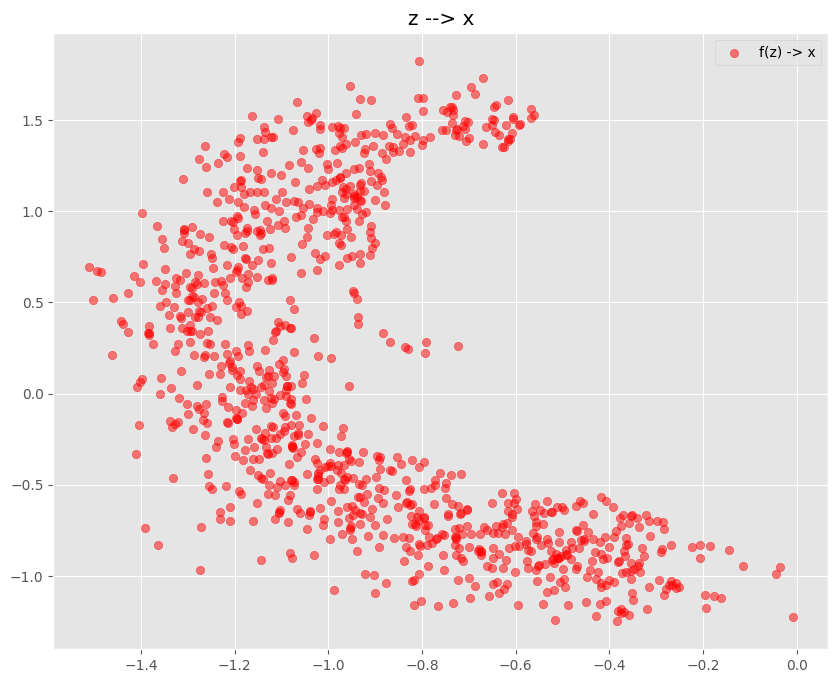

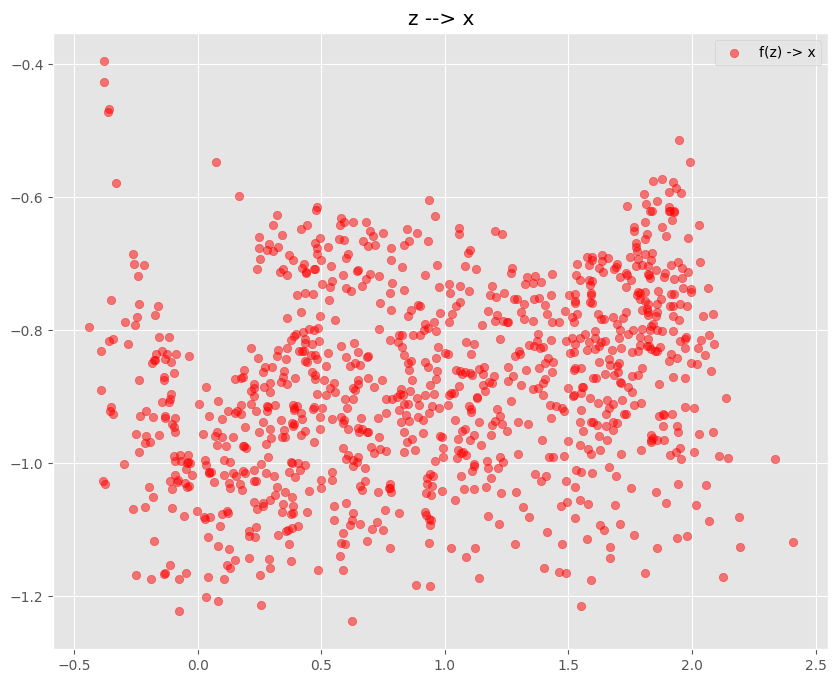

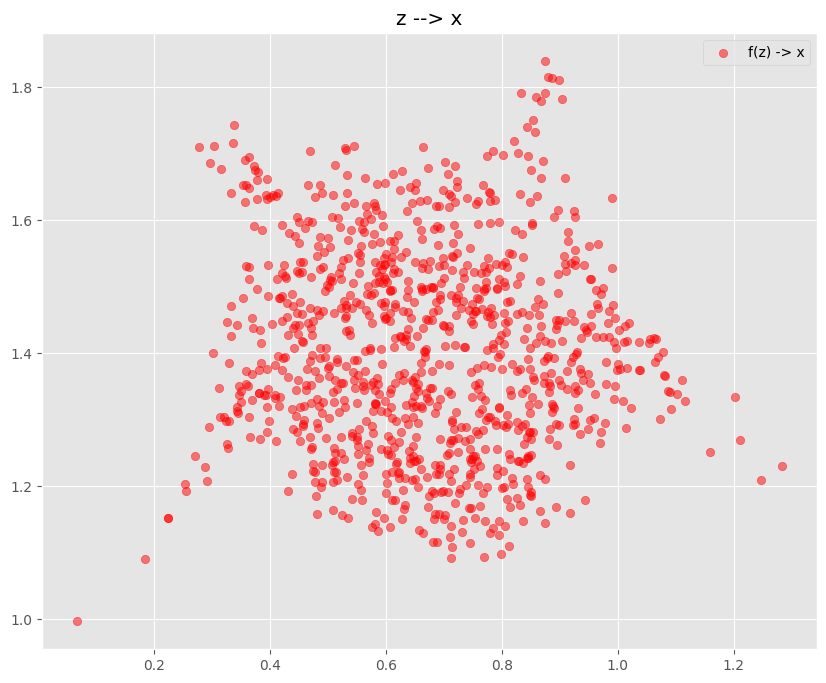

In [38]:
# Sample from trained NF (generative direction z -> x)
for i in range(3):
    samples = cnf.sample(num_samples=1000, H=torch.zeros(1000,1)+i).detach()
    fig = plt.figure(figsize=(10,8))
    #plt.scatter(_X_H[i, :, 0], _X_H[i, :, 1], c="b", label="Data", alpha=0.8)
    plt.scatter(samples[:, 0], samples[:, 1], c="r", alpha=0.5, label="f(z) -> x")
    plt.title("z --> x")
    plt.legend()

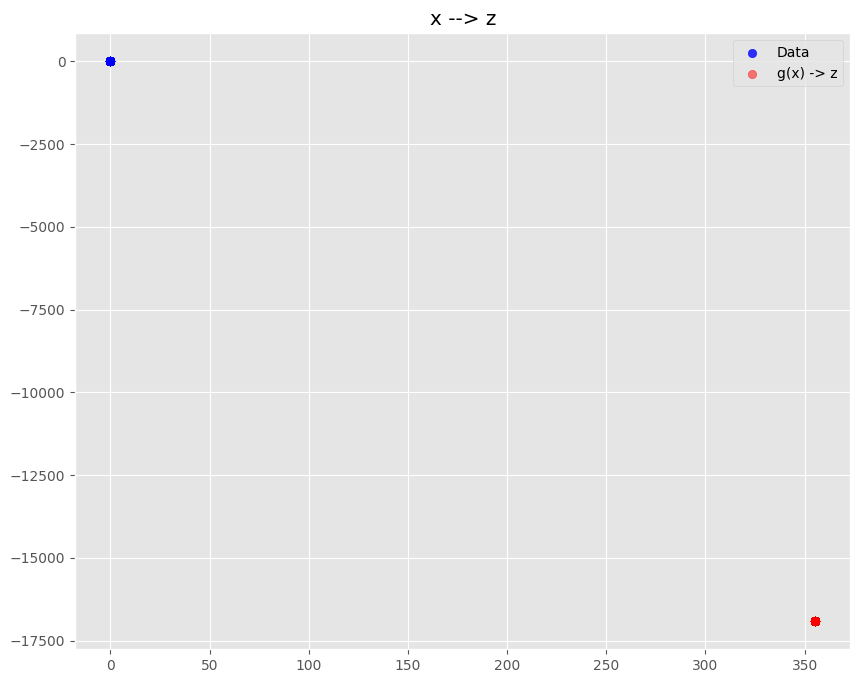

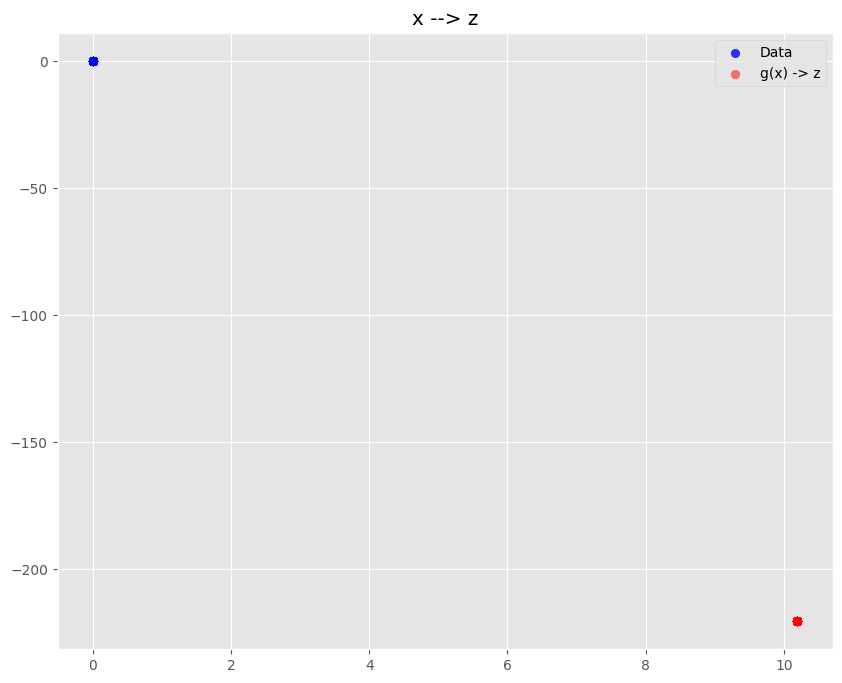

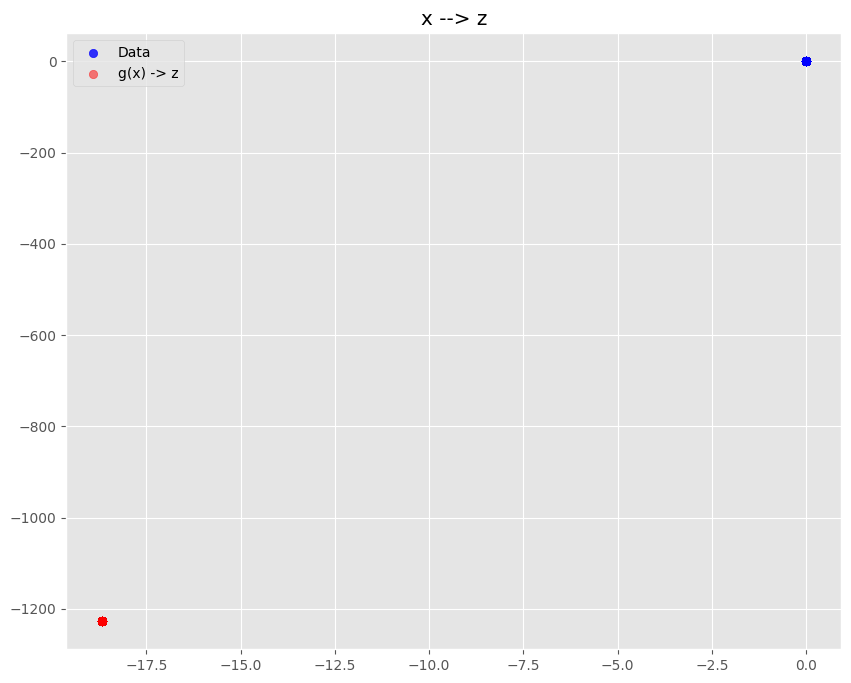

In [39]:
# Run data backward through the flow (normalizing direction x -> z)
for i in range(10):
    z_prior = cnf.backward(x=_X_H[i].view(-1,2), H=torch.zeros(1024,1)+i)[1].detach()
    fig = plt.figure(figsize=(10,8))
    plt.scatter(_X_H[i].view(-1,2)[:, 0], _X_H[i].view(-1,2)[:, 1], c="b", label="Data", alpha=0.8)
    plt.scatter(z_prior[:, 0], z_prior[:, 1], c="r", alpha=0.5, label="g(x) -> z")
    plt.title("x --> z")
    plt.legend()
    plt.show()